Given that we have concluded our EDA on the weather dataset, we have concluded that the relevant factors are 'Tavg', 'DewPoint', 'PrecipTotal', 'StnPressure', 'ResultSpeed', 'ResultDir'. We will now combine these weather features with both our train and test dataset.

From our research on [Culex Lifecycles](https://www.cdc.gov/mosquitoes/about/life-cycles/culex.html) and a paper on how the [climate affects the West Nile Virus spread](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4342965/), we have found out that temperature, humidity and rain affects multiple parts of a mosquito's lifecycle. This ranges from 0-10 days from when an egg is laid. Whereas wind and air pressure affect adult mosquitos. We have concluded that temperature, dew point and precipitation will have to be rolled but wind and air pressure will not need to be.

## Modeling: Logistic Regression

In [1]:
# Load in libraries
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score, mean_squared_error, plot_roc_curve, roc_auc_score

from imblearn.over_sampling import SMOTE

### Datasets preparation

In [2]:
# Read in datasets
train_final = pd.read_csv('./Datasets/train_final.csv')
test_final = pd.read_csv('./Datasets/test_final.csv')

In [3]:
# We define X train, X test and y. We drop features that have no relevance to Wnv
X_train = train_final.drop(columns=[
    'Address', 'Block', 'Street', 'AddressNumberAndStreet', 'Latitude',
    'Longitude', 'Species', 'Trap', 'AddressAccuracy', 'tot_mosquitos',
    'WnvPresent', 'month_year', 'year', 'month'
])

y_train = train_final['WnvPresent']

X_test = test_final.drop(columns=[
    'Address', 'Block', 'Street', 'AddressNumberAndStreet', 'Latitude',
    'Longitude', 'Species', 'Trap', 'AddressAccuracy', 'Id', 'month_year',
    'year', 'month'
])

# Scale columns that need to be scaled
# Instantiate StandardScaler
ss = StandardScaler()
# Define list of feature to be scaled
scale_list = [
    'StnPressure', 'ResultSpeed', 'ResultDir', 'DewPoint', 'DewPoint_roll2',
    'DewPoint_roll3', 'DewPoint_roll4', 'DewPoint_roll5', 'DewPoint_roll6',
    'Tavg', 'Tavg_roll2', 'Tavg_roll3', 'Tavg_roll4', 'Tavg_roll5',
    'Tavg_roll6', 'PrecipTotal', 'PrecipTotal_roll2', 'PrecipTotal_roll3',
    'PrecipTotal_roll4', 'PrecipTotal_roll5', 'PrecipTotal_roll6'
]

# Fit and transform X_train
X_train[scale_list] = ss.fit_transform(X_train[scale_list])
# Transform X_test
X_test[scale_list] = ss.transform(X_test[scale_list])

# SMOTE
sm = SMOTE(sampling_strategy={1: 8000}, random_state=42)
Xsm_train, ysm_train = sm.fit_resample(X_train, y_train)

# Dataframes now are Xsm_train, ysm_train and X_test

### Raw logistic regression with no tuning

In [4]:
# Sample with a logistic regression
logreg = LogisticRegression()
logreg.fit(Xsm_train, ysm_train)

D:\Users\user\anaconda3\envs\dsi\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [5]:
# Prepare for Kaggle
predict_probs = logreg.predict_proba(X_test).tolist()

pred = []
for i in range(0, len(predict_probs)):
               pred.append(predict_probs[i][1])
        
sample_submission_logreg = pd.DataFrame()
sample_submission_logreg['Id'] = test_final['Id']
sample_submission_logreg['WnvPresent'] = pred
sample_submission_logreg.reset_index(drop=True, inplace=True)
sample_submission_logreg.to_csv('sample_submission_logreg.csv', index=False)

### Scoring

In [6]:
# Accuracy and roc score of model
print('logreg accuracy:', logreg.score(Xsm_train, ysm_train))
print("logreg roc:", roc_auc_score(ysm_train,  [i[1] for i in logreg.predict_proba(Xsm_train)]))

logreg accuracy: 0.9309106667492106
logreg roc: 0.9784964506929965


LogisticRegression Kaggle score: **0.68684**

### GridSearch

In [7]:
# GridSearch with the following parameters tuning
# 'C': Inverse of regularization strength, smaller C= stronger regularization: [0.1, 1, 10]
# 'max_iter': Maximum number of iterations taken for the solvers to converge: [100, 1000, 10000]
# 'penalty': Regularize with l1(lasso) or l2(ridge): ['l1', 'l2']
# 'solver': 'liblinear'
grid = {
    'C': (0.1, 1, 10),
    'max_iter': [100, 1000, 10000],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear']
}
logreg = LogisticRegression()
logreg_cv = GridSearchCV(logreg, grid, cv=5, scoring='roc_auc')
logreg_cv.fit(Xsm_train, ysm_train)

GridSearchCV(cv=5, estimator=LogisticRegression(),
             param_grid={'C': (0.1, 1, 10), 'max_iter': [100, 1000, 10000],
                         'penalty': ['l1', 'l2'], 'solver': ['liblinear']},
             scoring='roc_auc')

In [8]:
# Check the params that give the best accuracy
print("logreg_cv best parameters: ",logreg_cv.best_params_)

logreg_cv best parameters:  {'C': 10, 'max_iter': 100, 'penalty': 'l1', 'solver': 'liblinear'}


In [9]:
# Fitting model with the best params
logreg2 = LogisticRegression(C= 10, max_iter= 100, penalty= 'l1', solver= 'liblinear')
logreg2.fit(Xsm_train, ysm_train)

LogisticRegression(C=10, penalty='l1', solver='liblinear')

In [10]:
# Prepare for kaggle
predict_probs2 = logreg2.predict_proba(X_test).tolist()

pred2 = []
for i in range(0, len(predict_probs2)):
               pred2.append(predict_probs2[i][1])
        
sample_submission_logreg2 = pd.DataFrame()
sample_submission_logreg2['Id'] = test_final['Id']
sample_submission_logreg2['WnvPresent'] = pred2
sample_submission_logreg2.reset_index(drop=True, inplace=True)
sample_submission_logreg2.to_csv('sample_submission_logreg2.csv', index=False)

### Scoring

In [11]:
# Accuracy and roc score of model
print('logreg2 accuracy:', logreg2.score(Xsm_train, ysm_train))
print("logreg2 roc:", roc_auc_score(ysm_train,  [i[1] for i in logreg2.predict_proba(Xsm_train)]))

logreg2 accuracy: 0.9692317216616109
logreg2 roc: 0.9920175318901017


LogisticRegression(C=10, max_iter=10000, penalty='l1', solver='liblinear') **Kaggle score: 0.73467**

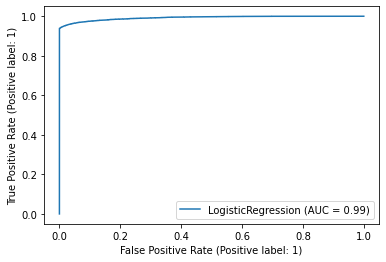

In [15]:
plot_roc_curve(logreg2, Xsm_train, ysm_train)
plt.show()

In [12]:
# Preparing to create a dataframe with features and coefficients
x_coef = list(logreg2.coef_)
Xsmcolumns = Xsm_train.columns
x_coef = x_coef[0]

In [13]:
# Creating a dataframe with features and coefficients from model
r_coef = pd.DataFrame({'Features': Xsmcolumns, 'Coefficient': x_coef})

In [14]:
# Sorting the data by coefficients in descending order
r_coef.sort_values(by = 'Coefficient', ascending = False)

,Features,Coefficient
177,Tavg_roll6,2.755077
167,DewPoint_roll2,0.978291
182,PrecipTotal_roll5,0.725619
179,PrecipTotal_roll2,0.610446
163,StnPressure,0.501334
...,...,...
81,T017,-12.214131
122,T099,-12.247645
66,T043,-12.321966
18,T046,-12.558769


### Summary & conclusion

|        Model        	| Features used 	|      Scaling     	|                                   Best params                                   	| Accuracy 	|  Roc  	| Kaggle score 	|
|:-------------------:	|:-------------:	|:----------------:	|:-------------------------------------------------------------------------------:	|:--------:	|:-----:	|--------------	|
| Logistic Regression 	|  Default set  	| Standard & Smote 	| Tavg_roll6, DewPoint_roll2,  PrecipTotal_roll5,  PrecipTotal_roll2, StnPressure 	|   0.969  	| 0.992 	| 0.73467      	|

This is our model with the best Kaggle score of **0.73467**. Logistic regression performs well when the dataset is linearly separable and when there is average or no multicollinearity between independent variables and also the number of mosquitos is likely to follow a poisson distribution which the sigmoid logit link mapping perform well on.  We select the appropriate variables to be used through EDA and Lasso regularization and rolling the relevant weather factors according to the Culex lifecycle thus enabling us to get the best result from Logistic regression. 